# Tutorial: Filtering

This notebook shows how to pre-process and filter trajectory dataframes using `nomad`. The `nomad` library currently provides functions for coordinate-system projection, and spatial, temporal, and quantity filtering.

In [ ]:
# %pip uninstall nomad -y
# %pip install git+https://github.com/Watts-Lab/nomad.git@filtering-demo#egg=nomad

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from datetime import datetime
import matplotlib.patches as patches

import nomad.filters as filters
from nomad.filters import to_projection, filter_users

### Load Data

For the following examples, we load test data from `nomad`.

In [30]:
raw_traj = pd.read_csv("../nomad/data/gc_sample.csv")
raw_traj['datetime'] = pd.to_datetime(raw_traj['timestamp'], unit='s')
raw_traj.head(10)

,uid,timestamp,latitude,longitude,datetime
0,wizardly_joliot,1704119340,38.321711,-36.667334,2024-01-01 14:29:00
1,wizardly_joliot,1704119700,38.321676,-36.667365,2024-01-01 14:35:00
2,wizardly_joliot,1704155880,38.320959,-36.666748,2024-01-02 00:38:00
3,wizardly_joliot,1704156000,38.320936,-36.666739,2024-01-02 00:40:00
4,wizardly_joliot,1704156840,38.320924,-36.666747,2024-01-02 00:54:00
5,wizardly_joliot,1704157860,38.320994,-36.666773,2024-01-02 01:11:00
6,wizardly_joliot,1704157920,38.320964,-36.666763,2024-01-02 01:12:00
7,wizardly_joliot,1704158820,38.320921,-36.666750,2024-01-02 01:27:00
8,wizardly_joliot,1704161280,38.320971,-36.666809,2024-01-02 02:08:00
9,wizardly_joliot,1704183120,38.321758,-36.666434,2024-01-02 08:12:00


### Project between coordinate systems

Many geospatial datasets comes in latitude/longitude (EPSG:4326). However, when doing spatial analysis—like checking whether a point is inside a polygon or measuring distances—it is often computationally cheaper to use coordinates in a projected coordinate system (like EPSG:3857) that uses consistent linear units. The `to_projection` function creates new columns `x` and `y` with the projected coordinates.


In [31]:
# Specify column names
traj_cols = {
    "user_id": "uid",
    "latitude": "latitude",
    "longitude": "longitude",
    "timestamp": "timestamp",
    "datetime": "datetime",
}

# Project to EPSG:3857 (Web Mercator)
traj = to_projection(traj=raw_traj,
                     from_crs="EPSG:4326",
                     to_crs="EPSG:3857",
                     traj_cols=traj_cols)

traj.head(10)

,uid,timestamp,latitude,longitude,datetime,x,y
0,wizardly_joliot,1704119340,38.321711,-36.667334,2024-01-01 14:29:00,-4.081789e+06,4.624973e+06
1,wizardly_joliot,1704119700,38.321676,-36.667365,2024-01-01 14:35:00,-4.081792e+06,4.624968e+06
2,wizardly_joliot,1704155880,38.320959,-36.666748,2024-01-02 00:38:00,-4.081724e+06,4.624866e+06
3,wizardly_joliot,1704156000,38.320936,-36.666739,2024-01-02 00:40:00,-4.081723e+06,4.624863e+06
4,wizardly_joliot,1704156840,38.320924,-36.666747,2024-01-02 00:54:00,-4.081724e+06,4.624861e+06
5,wizardly_joliot,1704157860,38.320994,-36.666773,2024-01-02 01:11:00,-4.081727e+06,4.624871e+06
6,wizardly_joliot,1704157920,38.320964,-36.666763,2024-01-02 01:12:00,-4.081725e+06,4.624867e+06
7,wizardly_joliot,1704158820,38.320921,-36.666750,2024-01-02 01:27:00,-4.081724e+06,4.624861e+06
8,wizardly_joliot,1704161280,38.320971,-36.666809,2024-01-02 02:08:00,-4.081731e+06,4.624868e+06
9,wizardly_joliot,1704183120,38.321758,-36.666434,2024-01-02 08:12:00,-4.081689e+06,4.624980e+06


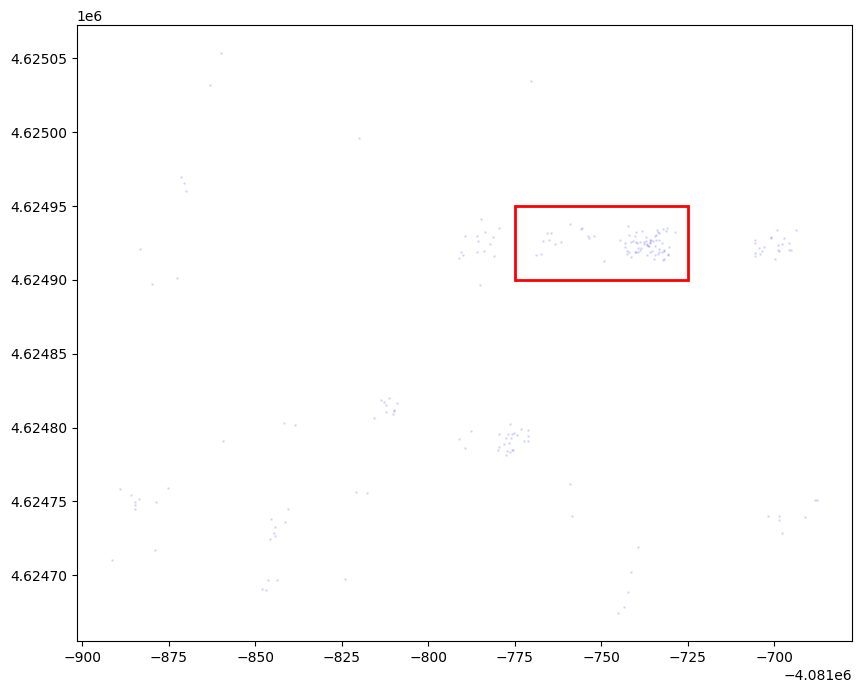

In [32]:
df = traj[traj['uid'] == "agitated_chebyshev"]

plt.figure(figsize=(10, 8))
plt.scatter(df['x'], df['y'], s=1, alpha=0.1, c='blue')

polygon_coords = [
    (-4.081775e+06, 4.62490e+06), 
    (-4.081775e+06, 4.62495e+06), 
    (-4.081725e+06, 4.62495e+06), 
    (-4.081725e+06, 4.62490e+06)
]
polygon = Polygon(polygon_coords)

polygon_patch = patches.Polygon(polygon.exterior.coords, closed=True, edgecolor='red', facecolor='none', linewidth=2, label="Polygon")
plt.gca().add_patch(polygon_patch)

# Show the plot
plt.show()

### Filter to a specified geometry

We often need to filter down the dataset to the most relevant records. This involves filtering along three key dimensions:
- Spatial Filtering: Keep only users with pings that fall within a specific geographic region (e.g., Philadelphia).
- Temporal Filtering: Restrict data to a time window of interest (e.g., January).
- Quantity-Based Filtering: Keep only users with sufficient activity as measured by a minimum number of pings.

These filtering functions help clean and prepare your dataset for downstream analysis by focusing only on users who are present, active, and engaged in the geographic area and timeframe you care about.

In [ ]:
polygon_coords = [
    (-4.081775e+06, 4.62490e+06), 
    (-4.081775e+06, 4.62495e+06), 
    (-4.081725e+06, 4.62495e+06), 
    (-4.081725e+06, 4.62490e+06)
]
polygon = Polygon(polygon_coords)

n0 = len(traj)

filtered_traj = filter_users(traj=traj, 
                             start_time=datetime.strptime("2024-01-01 00:00:00", "%Y-%m-%d %H:%M:%S"),
                             end_time=datetime.strptime("2024-01-31 23:59:00", "%Y-%m-%d %H:%M:%S"),
                             polygon=polygon,
                             min_active_days=2,
                             min_pings_per_day=10,
                             traj_cols=traj_cols)

n1 = len(filtered_traj)
unique_users = filtered_traj['uid'].unique()
print(f"Number of pings before filtering: {n0}")
print(f"Number of pings after filtering: {n1}")
print(f"Number of unique users: {len(unique_users)}")

Number of pings before filtering: 11533
Number of pings after filtering: 11533
Number of unique users: 17
